In [1]:
import numpy as np
from sklearn import datasets
import scipy.stats as stats

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline


## Inverse problem 

In [3]:
import scipy as sp
# Parameters
T = 0.05
N = 100
domain = [0, 1]
sigma_noise = 0.05
mu_u = -1
sigma_2_u = 0.05**2

n = 2*N
t = np.linspace(domain[0],domain[1], N)
t = np.round(t, 3)
d_k = 40

h = domain[1] / N

params = [0, 2.0, 0.2, 1.0, 0]

def problem_system(grid: np.array, params)-> np.array:

    output = np.zeros(grid.shape)
    for idx, point in enumerate(grid):
        if point <= 0.1:
            output[idx] = params[0]
        elif point <= 0.2:
            output[idx] = params[1]
        elif point <= 0.4:
            output[idx] = params[2]
        elif point <= 0.75:
            #output[idx] = params[3]
            output[idx] = 0.3*np.sin(2*np.pi*point*2)+params[3]
        else:
            output[idx] = point*params[4]
    
    return output



## Convolution matrix

In [4]:
import arviz as az

from models import deconvolution
from utils_plotting import plotmatrix, posterior_stats_1D, histogram


model = deconvolution(int(np.round(n/2)), int(n/16), 'reflect')
A = model.linear_operator(n)
A = A[1::2, :]

#A[0,0] = 0
#A[-1, -1] = 0

## Data Generation

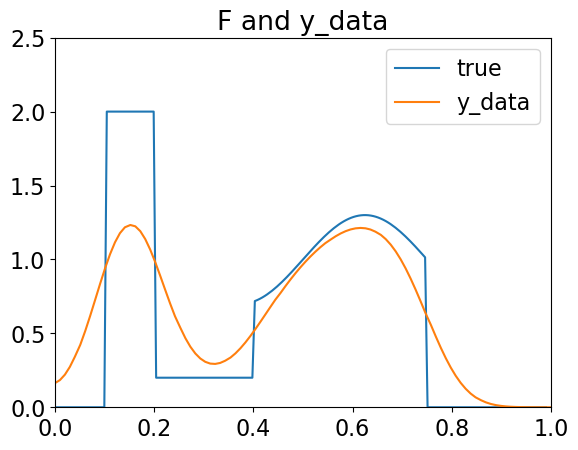

In [16]:
# Generate grid points
x = np.linspace(0, domain[1] - h, n)

# Construct the function f
f = problem_system(x, params)
#f = np.sin(10*x-0.2)
f = A@f
ind = f > 0
f *= ind

# Create y_data with noise
y_data = f + np.random.normal(0, sigma_noise, f.shape)

f = problem_system(x, params)

# Plot f and w
plt.figure()
plt.plot(x, f, label='true')
plt.plot(t, y_data, label='y_data')
plt.axis([domain[0], domain[1], 0, 2.5])
plt.title('F and y_data')
plt.legend()
plt.show()

Old targets

In [6]:
def log_likelihood(omega):
   return -(1/(2*sigma_noise))*np.linalg.norm(y_data - A @ np.exp(omega))**2

#def log_prior(omega):
#    return np.log(stats.multivariate_normal.pdf(omega, mean=np.mean(y_data)*np.ones(d), cov=0.5*np.eye(d)))

#def log_prior(omega):
#    theta = np.random.normal(0, 1, (k_star+1, 1))
#    return (1 + (np.sqrt(lambda_trunc)*phi_trunc.T).T @ theta)[0,0]


def log_prior(omega):
    prior_bnn = np.log(bnnmodel(torch.Tensor(omega)).detach().numpy())
    return prior_bnn

def log_target(omega):
    log_likelihood_value = log_likelihood(omega)
    log_prior_value = log_prior(omega)
    log_posterior = log_likelihood_value + log_prior_value
    return log_posterior

neg_log_post = lambda omega: -log_target(omega)

Old sampling

In [7]:
from samplers import RWM

n_chains = int(1e4)
n_burnin = int(1e4)
n_thinning = 50
d = n

#xi, logta, betas = RWM(d, n_chains, n_burnin, n_thinning, np.ones(d), log_target)

## Pyro BNN

In [8]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn


'''
Cauchy-jakaumia BNN:ään. 

'''

class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=5, prior_scale=10.):
        super().__init__()

        self.activation = nn.Tanh()  # or nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layer1(x))
        mu = self.layer2(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise

        # Sampling model
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu



In [9]:
bnn_model = BNN()

# Set Pyro random seed
pyro.set_rng_seed(42)

nuts_kernel = pyro.infer.NUTS(bnn_model, jit_compile=False)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
bnn_mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=50)

# Convert data to PyTorch tensors
x_train = torch.from_numpy(t).float()
y_train = torch.from_numpy(y_data).float()

# Run MCMC
bnn_mcmc.run(x_train, y_train)

Sample: 100%|██████████| 100/100 [01:32,  1.08it/s, step size=3.23e-03, acc. prob=0.337]


In [10]:
prior = pyro.infer.Predictive(model=bnn_model, posterior_samples=bnn_mcmc.get_samples())
x_test = torch.linspace(domain[0], domain[1], 3000)
preds = prior(x_test)

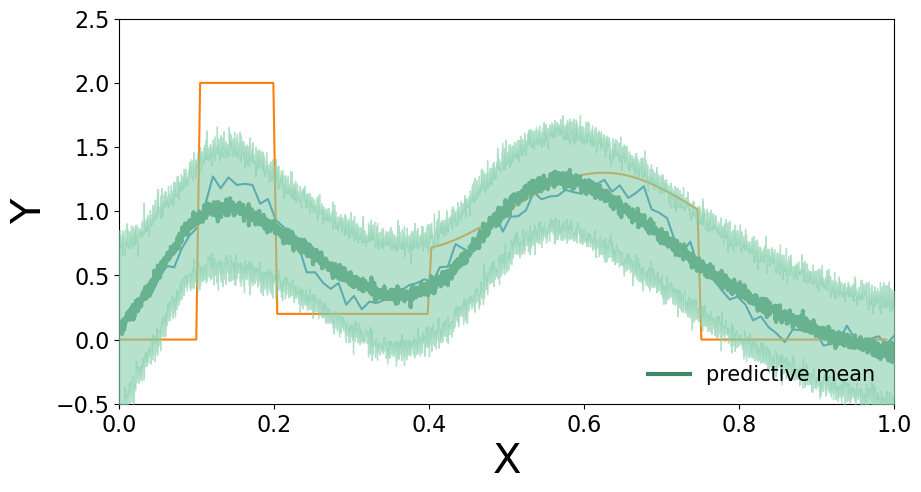

In [11]:
def plot_predictions(preds):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    xlims = [0, 1]
    ylims = [-0.5, 2.5]
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    plt.plot(t, y_data)
    plt.plot(x, f)
    ax.plot(x_test, y_pred, '-', linewidth=3, color="#408765", label="predictive mean")
    ax.fill_between(x_test, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

    plt.legend(loc=4, fontsize=15, frameon=False)

plot_predictions(preds)


In [12]:
omega = prior(torch.linspace(domain[0], domain[1], n))

## Sampling with NUTS

In [13]:
import torch
import pyro
import pyro.distributions as dist
import pyro.infer


A = torch.tensor(A, dtype=torch.float32)
y_data = torch.tensor(y_data, dtype=torch.float32)

# Define the model in Pyro
def inverse_model(A, y_data):
    n = A.size(1)  # Number of features
    
    # Priors for the weights (omega)
    omega = pyro.sample("omega", dist.Normal(1, 1).expand([n]).to_event(1))
        
    # Prior for the standard deviation of the noise
    sigma = pyro.sample("sigma", dist.HalfNormal(1.0))
    
    # Linear model
    mu = torch.matmul(A, omega)
    
    # Likelihood (sampling distribution) of observations
    with pyro.plate("data", len(y_data)):
        pyro.sample("obs", dist.Normal(mu, sigma), obs=y_data)

# Define the NUTS sampler
inverse_nuts_kernel = pyro.infer.NUTS(inverse_model)
mcmc = pyro.infer.MCMC(inverse_nuts_kernel, num_samples=200, warmup_steps=100)

# Run MCMC
mcmc.run(A, y_data)

# Extract samples
posterior_samples = mcmc.get_samples()

# Analyze the results
alpha_samples = posterior_samples['omega'].numpy()
sigma_samples = posterior_samples['sigma'].numpy()


Sample: 100%|██████████| 300/300 [00:46,  6.49it/s, step size=6.28e-02, acc. prob=0.908]


In [14]:
pyro_omega = np.mean(alpha_samples, axis=0)
pyro_omega.shape

(200,)

Text(0.5, 1.0, 'Setup of the problem')

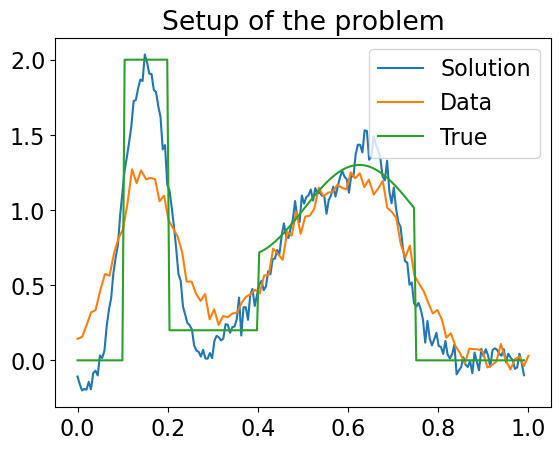

In [15]:
plt.plot(x, pyro_omega)
plt.plot(t, y_data)
plt.plot(x, f)
plt.legend(['Solution', 'Data', 'True'])
plt.title('Setup of the problem')
#plt.savefig('../plot_from_dev/working_gaussian.png')

# Fitting BNN to different signals and learning parameters